In [2]:
# imports
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

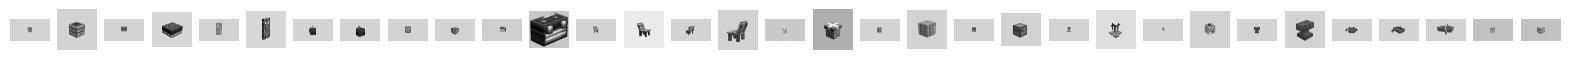

In [40]:

#test scene
#test_scene = cv2.imread("../Scenes/S6.png")
test_scene = cv2.imread("../scene.jpg")

test_scene = cv2.cvtColor(test_scene, cv2.COLOR_BGR2GRAY)

# load in all of the images
test_training_objects = []

# use os to get all of the files in the directory
for file in os.listdir("../Objects/"):
  # read in the image
  img = cv2.imread("../Objects/" + file)
  # convert to grayscale
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  # append to the list
  test_training_objects.append(gray)
  
test_training_objects


# plot the images
plt.figure(figsize=(20, 20))
for i in range(len(test_training_objects)):
  plt.subplot(1, len(test_training_objects), i+1)
  plt.axis('off')
  plt.imshow(test_training_objects[i],cmap="gray")

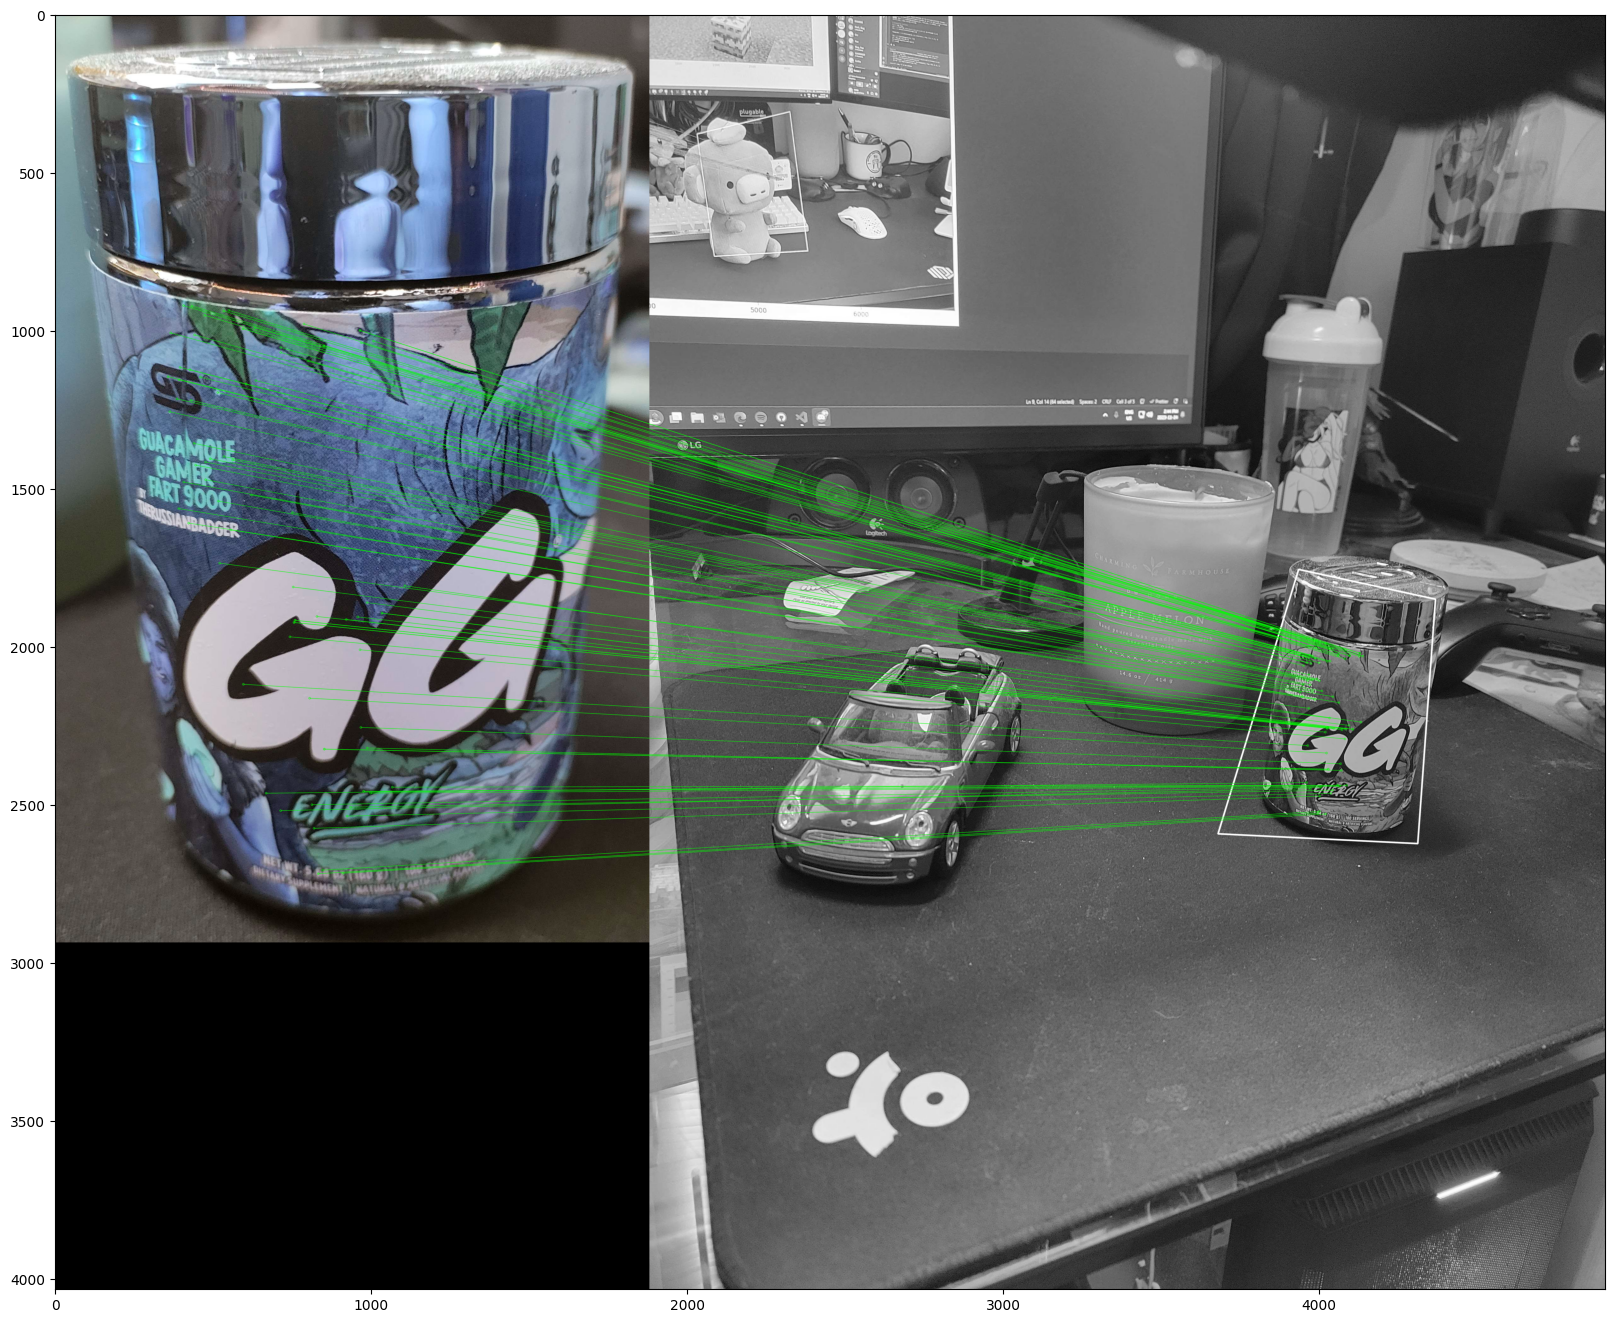

In [41]:
#https://docs.opencv.org/3.4/d1/de0/tutorial_py_feature_homography.html

#create ORB
orb = cv2.SIFT_create()
#train_object = test_training_objects[11]
train_object = cv2.imread("../object3.jpg", cv2.COLOR_BGR2GRAY)

keypoint, descriptors = orb.detectAndCompute(train_object, None)
keypoint2, descriptors2 = orb.detectAndCompute(test_scene, None)

bf = cv2.BFMatcher()
matches = bf.knnMatch(descriptors, descriptors2, k=2)

#apply funny ratio 
good_results = []
temp = []

for m,n in matches:
    if m.distance < 0.6*n.distance:
        good_results.append([m])
        temp.append(m)


# draw box around detected image
temp = temp[:100]
src_pts = np.float32([ keypoint[m.queryIdx].pt for m in temp ]).reshape(-1,1,2)
dst_pts = np.float32([ keypoint2[m.trainIdx].pt for m in temp ]).reshape(-1,1,2)
M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
matchesMask = mask.ravel().tolist()
h, w, _ = train_object.shape
pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
dst = cv2.perspectiveTransform(pts,M)
img2 = cv2.polylines(test_scene,[np.int32(dst)], True, 255, 3, cv2.LINE_AA)

draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)

img3 = cv2.drawMatches(train_object, keypoint,img2,keypoint2,temp,None,**draw_params)

fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111)
ax.imshow(img3,cmap="gray")
plt.show()




In [3]:
# open all images in ../Objects/ and convert them to pngs, then save them to ../Objects/
for file in os.listdir("../Scenes/"):
  # read in the image
  img = cv2.imread("../Scenes/" + file)
  # save the image
  cv2.imwrite("../Scenes/" + file[:-4] + ".png", img)